<a href="https://colab.research.google.com/github/Raissa-hue310/Assignment-14-Ethical-AI-Analysis-and-Explainability/blob/main/Assignment14_ethical_ai_income.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 14: Ethical AI Analysis and Explainability
## Student: Raïssa Matho Mekjele
## Course: Data Analytics and Business Intelligence Analyst
## Institution: Willis College

# Install and Imports librairies

In [2]:
# Task 0: Install required libraries
!pip install fairlearn shap lime --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 36.5 MB/s eta 0:00:00


In [3]:
# Task 0: Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate

import shap
from lime.lime_tabular import LimeTabularExplainer

import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (8, 5)
RANDOM_STATE = 42


# 1. Dataset Preparation

We’ll use the Adult dataset (UCI Adult Income) from OpenML.
Sensitive attribute: sex (Male / Female).

In [4]:
# Task 1: Load dataset (Adult Income from OpenML)
adult = fetch_openml("adult", version=2, as_frame=True)
data = adult.frame.copy()

# Inspect the first rows
data.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [5]:
# Task 1: Basic cleaning and target/sensitive feature setup

# Replace "?" with NaN and drop missing rows
data = data.replace("?", np.nan).dropna()

# Define target variable (income)
y = (data["class"] == ">50K").astype(int)  # 1 => income >50K, 0 => <=50K

# Sensitive attribute: sex
sensitive_feature = data["sex"]

# Drop target and irrelevant columns from X
X = data.drop(columns=["class"])

# Check types
X.dtypes


,0
age,int64
workclass,category
fnlwgt,int64
education,category
education-num,int64
marital-status,category
occupation,category
relationship,category
race,category
sex,category


In [6]:
# Task 1: Define numeric and categorical columns

numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

numeric_cols, categorical_cols


(['age',
  'fnlwgt',
  'education-num',
  'capital-gain',
  'capital-loss',
  'hours-per-week'],
 ['workclass',
  'education',
  'marital-status',
  'occupation',
  'relationship',
  'race',
  'sex',
  'native-country'])

# 2.Model Training

In [7]:
# Task 2: Preprocessing pipeline

numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)

# Full pipeline
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", log_reg)
])


In [8]:
# Task 2: Train-test split

X_train, X_test, y_train, y_test, sens_train, sens_test = train_test_split(
    X, y, sensitive_feature,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)


In [9]:
# Task 2: Train the model

clf.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])

# 3. Model Evaluation (Accuracy, Confusion Matrix, Classification Report)

In [10]:
# Task 3: Predictions and basic metrics

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["<=50K", ">50K"]))


Accuracy: 0.8460

Confusion Matrix:
[[6311  492]
 [ 901 1341]]

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90      6803
        >50K       0.73      0.60      0.66      2242

    accuracy                           0.85      9045
   macro avg       0.80      0.76      0.78      9045
weighted avg       0.84      0.85      0.84      9045



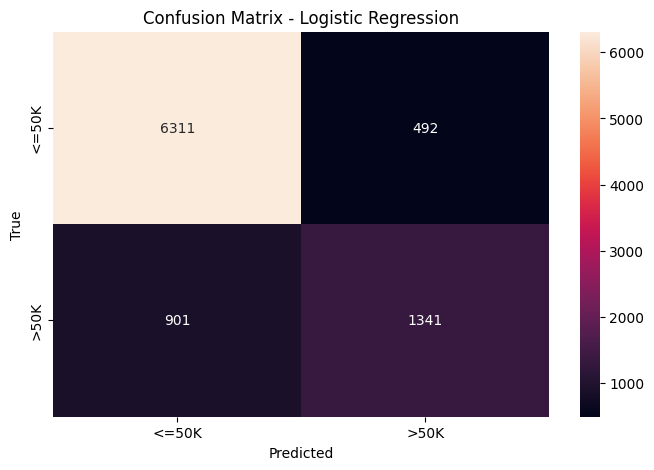

In [11]:
# Task 3: Visualize confusion matrix

import seaborn as sns

plt.figure()
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["<=50K", ">50K"], yticklabels=["<=50K", ">50K"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


# 4. Fairness Analysis with Fairlearn
We analyze metrics across groups defined by sex.

In [12]:
# Task 4: Fairness metrics with Fairlearn

# Prediction probabilities and class predictions
y_pred = clf.predict(X_test)

metrics_dict = {
    "accuracy": accuracy_score,
    "selection_rate": selection_rate,
    "false_positive_rate": false_positive_rate,
    "true_positive_rate": true_positive_rate
}

mf = MetricFrame(
    metrics=metrics_dict,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sens_test
)

print("Overall metrics:")
print(mf.overall)

print("\nMetrics by group (sex):")
mf.by_group


Overall metrics:
accuracy               0.845992
selection_rate         0.202653
false_positive_rate    0.072321
true_positive_rate     0.598127
dtype: float64

Metrics by group (sex):


,accuracy,selection_rate,false_positive_rate,true_positive_rate
sex,,,,
Female,0.917409,0.078136,0.020744,0.482094
Male,0.811980,0.261955,0.103343,0.620543


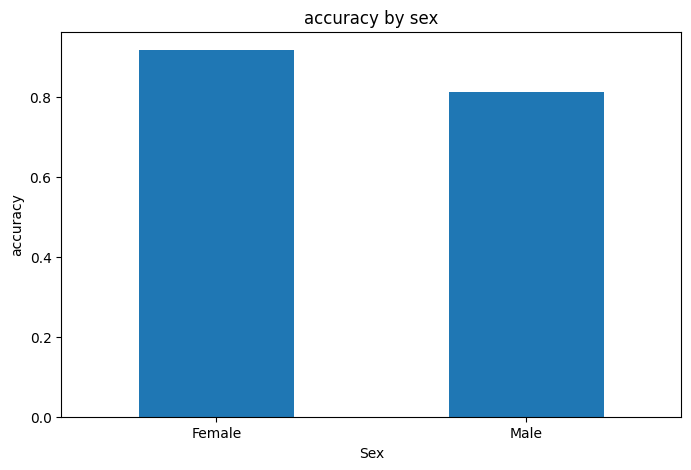

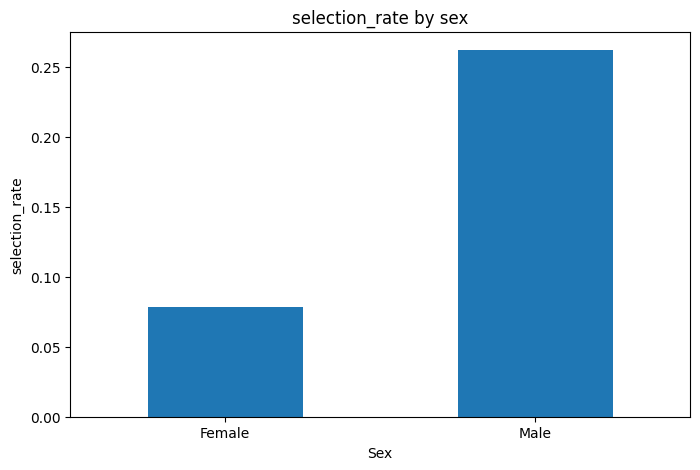

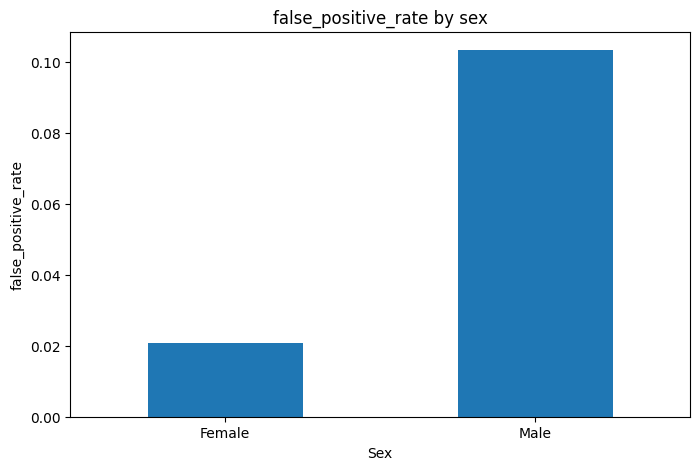

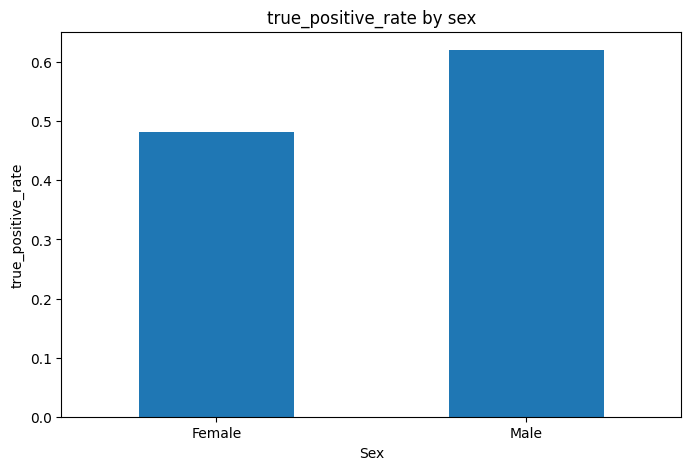

In [13]:
# Task 4: Visualize fairness metrics by sex

for metric_name in metrics_dict.keys():
    plt.figure()
    mf.by_group[metric_name].plot(kind="bar")
    plt.title(f"{metric_name} by sex")
    plt.ylabel(metric_name)
    plt.xlabel("Sex")
    plt.xticks(rotation=0)
    plt.show()


# 5.Explainability with SHAP

We’ll use SHAP LinearExplainer on a sample.

In [25]:
preprocessor = clf.named_steps["preprocessor"]
model = clf.named_steps["model"]

# Transform full training data
X_train_enc = preprocessor.transform(X_train)
X_test_enc = preprocessor.transform(X_test)

# Convert to dense
if hasattr(X_train_enc, "todense"):
    X_train_enc = X_train_enc.todense()
    X_test_enc = X_test_enc.todense()

X_train_enc = np.array(X_train_enc)
X_test_enc = np.array(X_test_enc)

feature_names = preprocessor.get_feature_names_out()


In [26]:

import shap

explainer = shap.LinearExplainer(
    model,
    X_train_enc,
    feature_perturbation="interventional"
)



In [30]:
shap_values = explainer.shap_values(X_test_enc)


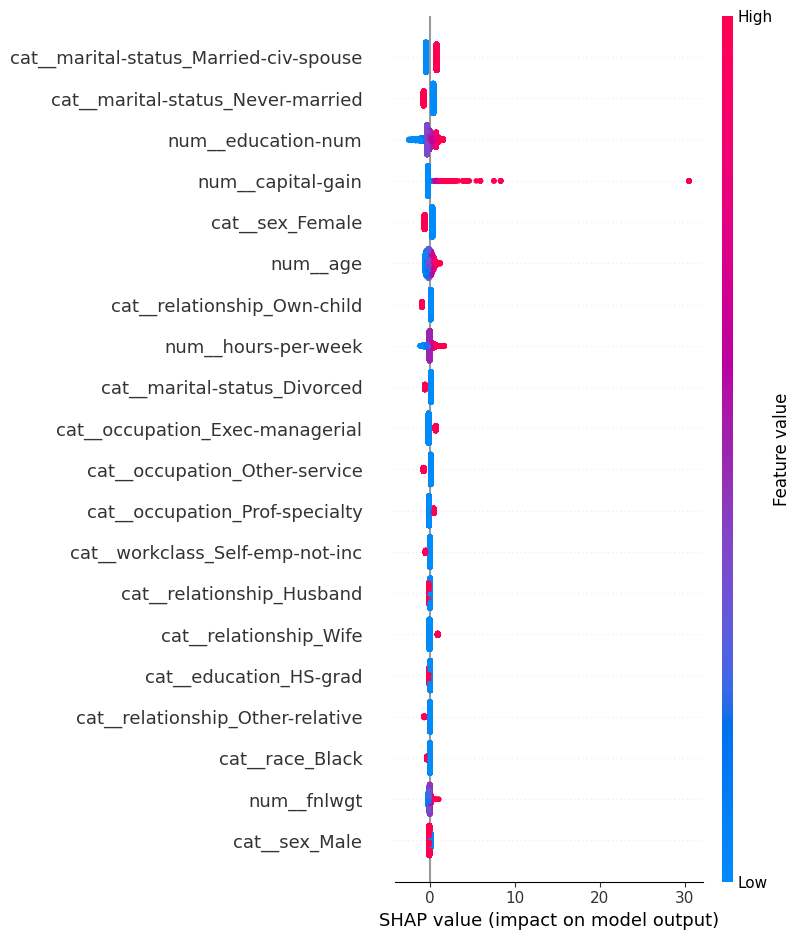

In [31]:
shap.summary_plot(shap_values, X_test_enc, feature_names=feature_names)



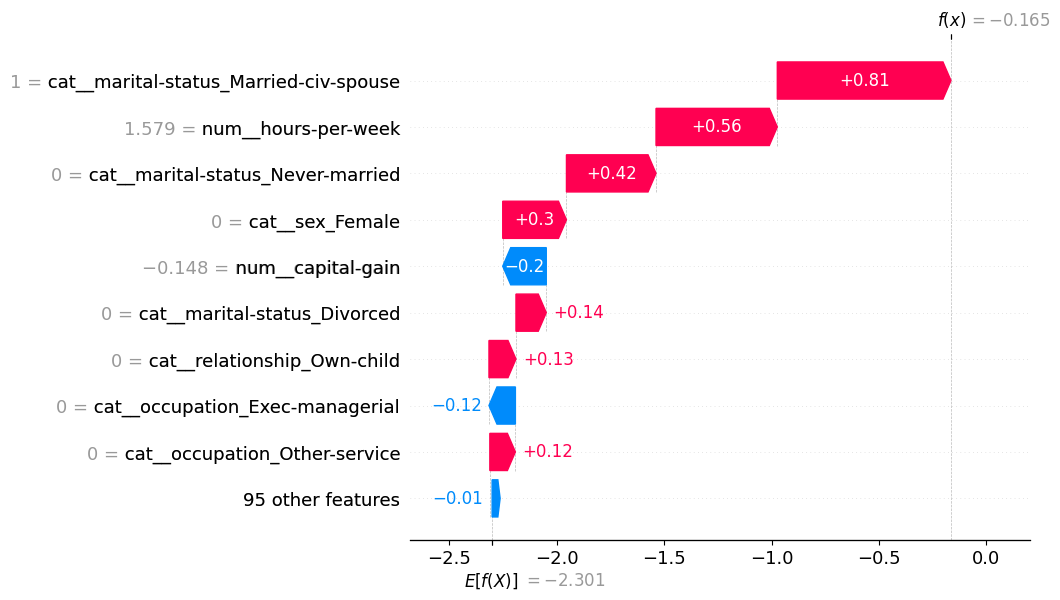

In [33]:
i = 0  # index to explain

# Create a SHAP Explanation object manually
exp = shap.Explanation(
    values = shap_values[i],
    base_values = explainer.expected_value,
    data = X_test_enc[i],
    feature_names = feature_names
)

shap.plots.waterfall(exp, max_display=10)


# 6. Explainability with LIME
For LIME we need the encoded feature space.

In [34]:
# Task 6: Prepare encoded data for LIME

# Get fitted preprocessor and model
fitted_preprocessor = clf.named_steps["preprocessor"]
fitted_model = clf.named_steps["model"]

X_train_enc = fitted_preprocessor.transform(X_train)
X_test_enc = fitted_preprocessor.transform(X_test)

# If sparse, convert to dense for LIME
if hasattr(X_train_enc, "todense"):
    X_train_enc = X_train_enc.todense()
    X_test_enc = X_test_enc.todense()

feature_names = fitted_preprocessor.get_feature_names_out()
class_names = ["<=50K", ">50K"]


In [36]:
# Task 6: Create LIME explainer

explainer_lime = LimeTabularExplainer(
    training_data=np.array(X_train_enc),
    feature_names=feature_names,
    class_names=class_names,
    mode="classification",
    discretize_continuous=True
)


LIME explanation (feature contributions):
('num__capital-gain <= -0.15', -0.6092158719174765)
('cat__native-country_Cambodia <= 0.00', -0.21190384655921776)
('cat__native-country_England <= 0.00', -0.16792231980822994)
('cat__native-country_Ireland <= 0.00', -0.15932586922626812)
('cat__native-country_Portugal <= 0.00', -0.1558494188968133)
('num__capital-loss <= -0.22', -0.14897549585864486)
('0.00 < cat__marital-status_Married-civ-spouse <= 1.00', 0.14325436042021422)
('cat__native-country_Laos <= 0.00', 0.13450718600295097)
('cat__relationship_Wife <= 0.00', -0.10799312078440822)
('cat__native-country_Hong <= 0.00', -0.035023792679757575)


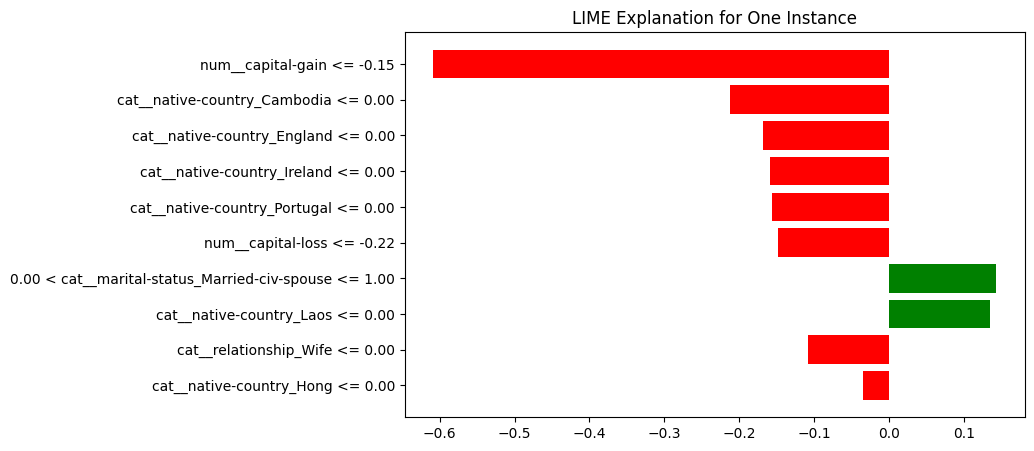

In [37]:
# Task 6: Explain a single prediction with LIME

# Pick one instance
i = 0
x_test_row = np.array(X_test_enc)[i]

def predict_proba_encoded(X_in):
    return fitted_model.predict_proba(X_in)

exp = explainer_lime.explain_instance(
    data_row=x_test_row,
    predict_fn=predict_proba_encoded,
    num_features=10
)

# Display explanation
print("LIME explanation (feature contributions):")
for item in exp.as_list():
    print(item)

# Plot the explanation
fig = exp.as_pyplot_figure()
plt.title("LIME Explanation for One Instance")
plt.show()
